<a href="https://colab.research.google.com/github/Esteves4/IA-Proj/blob/main/IA_Proj_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset import

**API Install**

In [ ]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



**Importing kaggle.json**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


**Download dataset**

In [ ]:
!kaggle datasets download -d lasaljaywardena/music-instrument-images-dataset

music-instrument-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q music-instrument-images-dataset.zip

replace music_data_img.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Pre-processing

In [ ]:
import cv2
import pandas as pd 

basepath = "music_instruments_images/"
music_df = pd.read_csv("music_data_img.csv")

# Removing lines from csv where image were not unzipped or causing problems
drop_lines = []

# Getting images index with a reading problem
for index, row in music_df.iterrows():
  img = cv2.imread(basepath + row.Image_File)

  if img is None:
    drop_lines.append(index)

# Removing those images from the dataframe
for i in drop_lines:
  music_df.drop(i, inplace=True)

music_df.head()

,Label,Instrument_Type,Image_File
0,yamaha (sy-77) music synthesizer,Keyboard / Piano,music_instruments_images/1634109508851_Yamaha ...
1,srx-718 bass bin (pair),Studio / Live Music Equipment,music_instruments_images/1634109509147_SRX718 ...
2,piano (malcom mendis piano),Keyboard / Piano,music_instruments_images/1634109509344_Piano M...
3,yamaha semi acoustic guitars,String Instrument / Amplifier,music_instruments_images/1634109509573_Yamaha ...
4,yamaha guitar,String Instrument / Amplifier,music_instruments_images/1634109510073_Yamaha ...


**Data visualization**

In [ ]:
import plotly.express as px

fig = px.histogram(music_df, x="Instrument_Type")
fig.show()


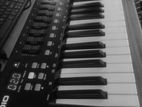
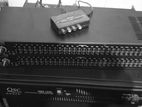
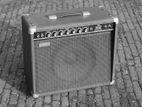
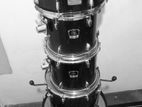
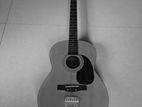
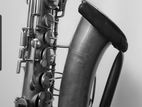
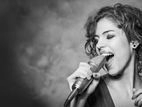
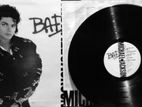

In [ ]:
import cv2
from plotly.subplots import make_subplots

class_list = music_df.Instrument_Type.unique().tolist()

fig = make_subplots(rows=2, cols=4, subplot_titles=class_list)

for n,i in enumerate(class_list):
  temp = music_df[music_df.Instrument_Type == i].sample()
  img = cv2.imread(basepath + temp.Image_File.values[0])
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  fig.add_trace(px.imshow(img).data[0], row=int(n/4)+1, col=n%4+1)

fig.show()

**Importing image in Dataframe**

In [ ]:
imgs = []

for index, row in music_df.iterrows():
  img = cv2.imread(basepath + row.Image_File)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  imgs.append(gray)

music_df["Image_Data"] = imgs

# Feature Extraction

In [ ]:
def computeentropy(image):
  image = image.flatten()
  lensig=image.size
  symset=list(set(image.flatten()))
  numsym=len(symset)
  propab=[np.size(image[image==i])/(1.0*lensig) for i in symset]
  ent=np.sum([p*np.log2(1.0/p) for p in propab])
  return ent;

In [ ]:
import cv2
import numpy as np
from scipy.stats import kurtosis, skew

var = []
mean = []
std = []
entropy = []
img_skew = []
img_kurtosis = []


for index, row in music_df.iterrows():
  img = row.Image_Data.flatten()

  var.append(round(np.var(img),2))
  mean.append(round(np.mean(img),2))
  std.append(round(np.std(img),2))
  entropy.append(round(computeentropy(img),2))
  img_skew.append(round(skew(img),2))
  img_kurtosis.append(round(kurtosis(img),2))
  


music_df["var"] = var
music_df["mean"] = mean
music_df["std"] = std
music_df["entropy"] = entropy
music_df["skew"] = img_skew
music_df["kurtosis"] = img_kurtosis

**Correlation matrix of the features**

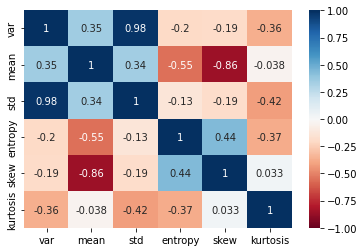

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

corr_data = music_df[["var","mean","std","entropy","skew","kurtosis"]]
corr_matrix = corr_data.corr()

sn.heatmap(corr_matrix, cmap='RdBu',vmin=-1, vmax=1, center=0, annot=True)
plt.show()

# Training

In [ ]:
# To use the music_df variable, features columns to use: var, mean, std, entropy, skew and kurtosis
#                             , class columns to use: Label (?), Instrument_Type
#                             , data column to be trainned:  Image_Data                            

music_df.head()

,Label,Instrument_Type,Image_File,Image_Data,var,mean,std,entropy,skew,kurtosis
0,yamaha (sy-77) music synthesizer,Keyboard / Piano,music_instruments_images/1634109508851_Yamaha ...,"[[172, 159, 168, 172, 154, 175, 161, 166, 166,...",3246.48,101.01,56.98,7.66,0.61,-0.23
1,srx-718 bass bin (pair),Studio / Live Music Equipment,music_instruments_images/1634109509147_SRX718 ...,"[[255, 255, 254, 255, 255, 255, 255, 254, 254,...",9860.48,153.93,99.30,5.23,-0.09,-1.84
2,piano (malcom mendis piano),Keyboard / Piano,music_instruments_images/1634109509344_Piano M...,"[[205, 203, 201, 199, 201, 205, 206, 205, 211,...",3943.11,76.88,62.79,7.33,1.11,0.25
3,yamaha semi acoustic guitars,String Instrument / Amplifier,music_instruments_images/1634109509573_Yamaha ...,"[[122, 127, 127, 122, 118, 117, 115, 113, 112,...",1028.36,113.62,32.07,5.84,-2.08,3.12
4,yamaha guitar,String Instrument / Amplifier,music_instruments_images/1634109510073_Yamaha ...,"[[251, 253, 247, 252, 240, 222, 245, 253, 251,...",5224.48,99.17,72.28,7.62,0.38,-1.17


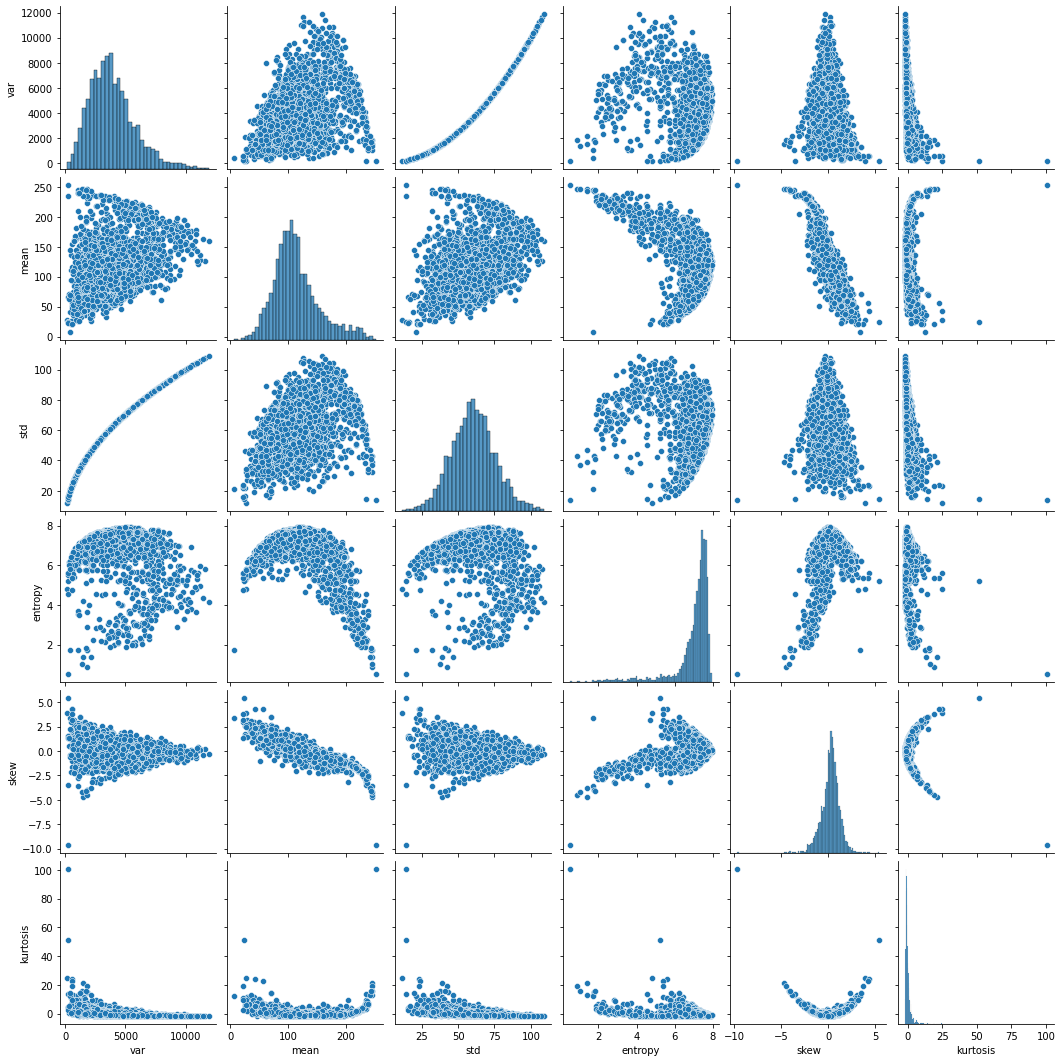

In [ ]:
#Hierarchical clustering
import seaborn as sns

sns.pairplot(music_df)

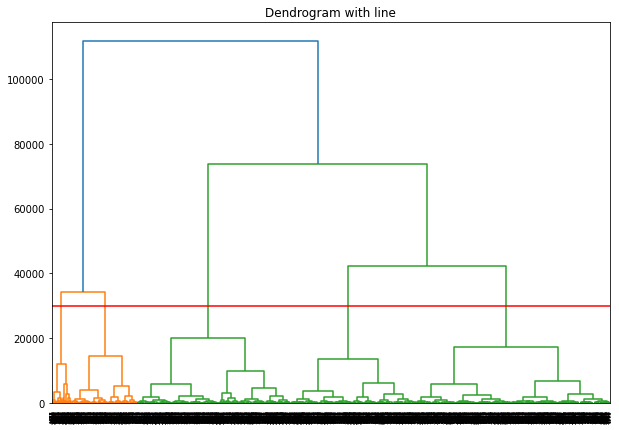

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendrogram with line")

music_df = music_df.drop('Label', axis=1)
music_df = music_df.drop('Instrument_Type', axis=1)
music_df = music_df.drop('Image_File', axis=1)
music_df = music_df.drop('Image_Data', axis=1)

clusters = shc.linkage(music_df, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)

plt.axhline(y = 30000, color = 'r', linestyle = '-')

# Validation

# Test